In [1]:
from utils_project import * 

from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold

from scipy.stats import gaussian_kde
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

from pandas.plotting import lag_plot

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from matplotlib.patches import Rectangle

User detected: /Users/matty_gee
Initial n=693
Replication n=279


In [2]:
# realworld likability and impact
impact_cols = [col for col in data.columns if 'impact' in col and 'self' not in col and 'mean' not in col and 'attention' not in col]
impact_cols = [col for col in impact_cols if not any([role in col for role in character_roles])]
liking_cols = [col for col in data.columns if 'likability' in col and 'self' not in col and 'mean' not in col  and 'attention' not in col]
liking_cols = [col for col in liking_cols if not any([role in col for role in character_roles])]

data['likability_relationships_mean'] = np.nanmean(data[liking_cols],1)
data['impact_relationships_mean'] = np.nanmean(data[impact_cols],1)
data['likability_realworld_mean'] = np.mean((data['likability_relationships_mean'], data['self_likability']), 0)
data['impact_realworld_diff'] = data['impact_relationships_mean'].values - data['self_impact'].values

# avg & diff for characters
data['likability_task_mean'] = np.mean((data['likability_mean'], data['self_likability']), 0)
data['impact_task_diff'] = data['impact_mean'].values - data['self_impact'].values

# Infer subjects' goal locations: use own place, real-world relationships etc
power is competitive process: self-power & other-power has a negative relationship
- in some sense, 0 sum
affiliation is cooperative process: self-likability and other-likability has a positive relationship

based on people's perceptions of themselves on these two dimensions we might be able to infer a goal quadrant 


In [5]:
self_xy = data[['sub_id', 'self_likability', 'self_impact', 
                          'likability_mean', 'impact_mean', 
                          'affil_mean_mean', 'power_mean_mean', 
                          'likability_relationships_mean', 'impact_relationships_mean',
                          'likability_task_mean', 'impact_task_diff',
                          'likability_realworld_mean', 'impact_realworld_diff',
                          'factor_social', 'demo_ladder_rate']]

# split factor into 4 bins
self_xy['factor_social'] = pd.qcut(self_xy['factor_social'], q=4, labels=[1, 2, 3, 4])

# scale some variables between -1 and 1
for col in ['self_likability', 'self_impact', 'likability_mean', 'impact_mean', 
            'likability_relationships_mean', 'impact_relationships_mean',
            'likability_task_mean', 'impact_task_diff',
            'likability_realworld_mean', 'impact_realworld_diff']:
    self_xy[col] = (self_xy[col] - 50) / 50 

# mask
mask = np.isfinite(self_xy['self_likability']) & np.isfinite(self_xy['self_impact'])
self_xy = self_xy[mask]

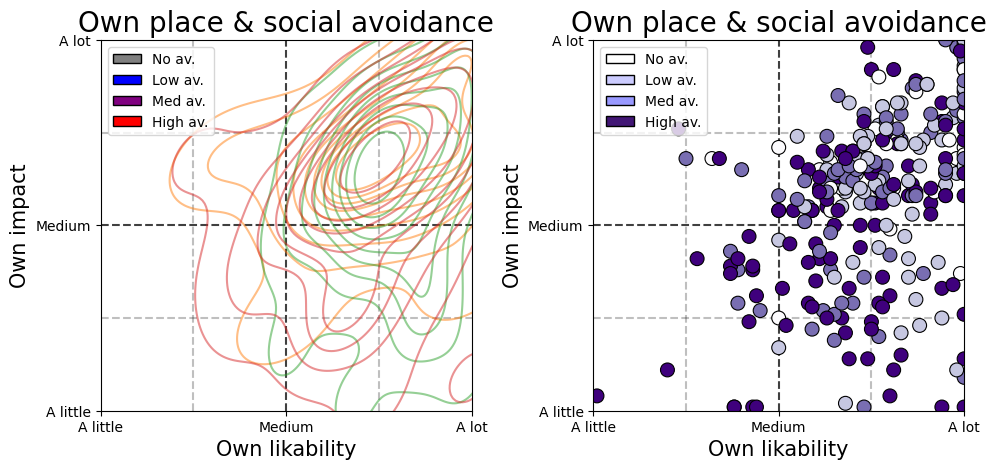

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

# plot a kde for the self_xy for factor_social_min == 1
for g, cmap in enumerate(['Greys', 'Blues', 'Purples', 'Reds']):
    sns.kdeplot(ax=axs[0], data=self_xy[self_xy['factor_social']==g],
                x='self_likability', y='self_impact', 
                shade=False, shade_lowest=False, alpha=0.5)
# create a legend
legend_elements = [Patch(facecolor='grey', edgecolor='black', label='No av.'),
                    Patch(facecolor='blue', edgecolor='black', label='Low av.'),
                    Patch(facecolor='purple', edgecolor='black', label='Med av.'),
                    Patch(facecolor='red', edgecolor='black', label='High av.')]
axs[0].legend(handles=legend_elements, loc='upper left')

sns.scatterplot(ax=axs[1], data=self_xy, x='self_likability', y='self_impact', 
                           c=self_xy['factor_social'], 
                           cmap='Purples', s=100, edgecolor='black')

# get rgb values for white, light purple, purple, dark purple
white = np.array([255,255,255])/255
lightpurple = np.array([204,204,255])/255
purple = np.array([153,153,255])/255
darkpurple = np.array([66,22,117])/255

# add a legend with white, light purple, purple, dark purple
legend_elements = [Patch(facecolor=white, edgecolor='black', label='No av.'),
                    Patch(facecolor=lightpurple, edgecolor='black', label='Low av.'),
                    Patch(facecolor=purple, edgecolor='black', label='Med av.'),
                    Patch(facecolor=darkpurple, edgecolor='black', label='High av.')]
axs[1].legend(handles=legend_elements, loc='upper left')

# loop over axes
for ax in axs:
    ax.set_aspect('equal')
    ax.set_title('Own place & social avoidance', fontdict={'fontsize': 20})
    ax.set_xlabel('Own likability', fontdict={'fontsize': 15})
    ax.set_ylabel('Own impact', fontdict={'fontsize': 15})
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_xticklabels(['A little','Medium','A lot'])
    ax.set_yticklabels(['A little','Medium','A lot'])
    ax.axhline(0, color='k', linestyle='--', alpha=0.75, zorder=0)
    ax.axvline(0, color='k', linestyle='--', alpha=0.75, zorder=0)
    ax.axhline(.5, color='k', linestyle='--', alpha=0.25, zorder=0)
    ax.axvline(.5, color='k', linestyle='--', alpha=0.25, zorder=0)
    ax.axhline(-.5, color='k', linestyle='--', alpha=0.25, zorder=0)
    ax.axvline(-.5, color='k', linestyle='--', alpha=0.25, zorder=0)
plt.tight_layout()
plt.show()


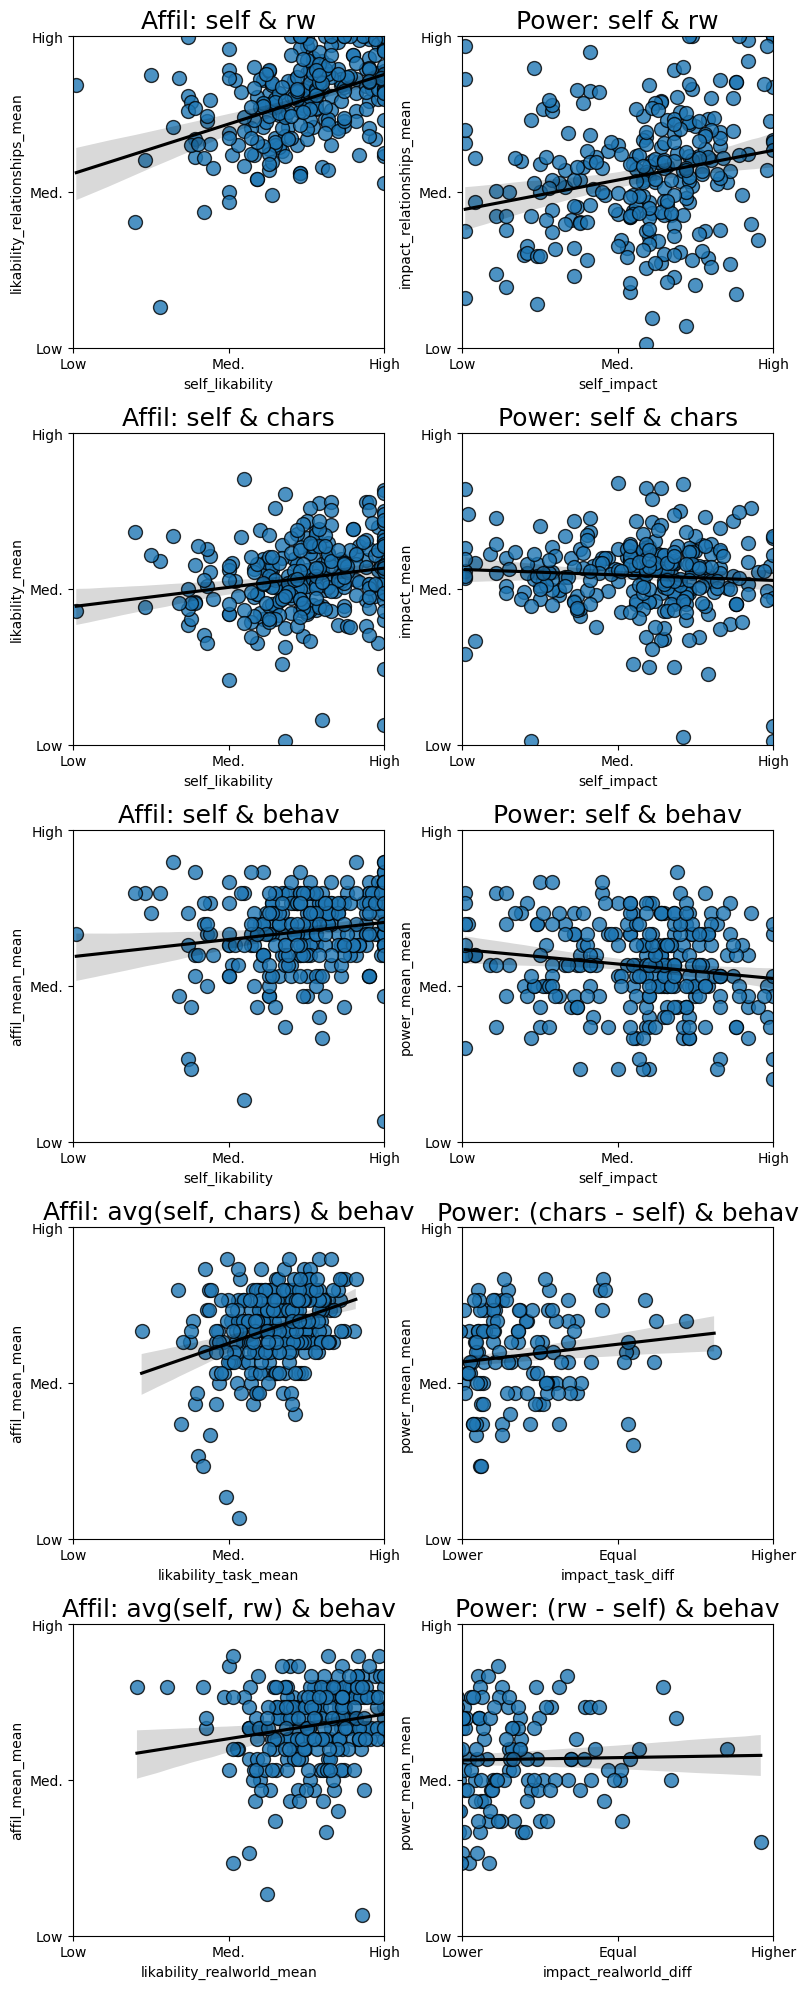

In [8]:
plot_dict = {
             # self & realworld ratings 
             'Affil: self & rw': {'x': 'self_likability', 'y': 'likability_relationships_mean'}, 
             'Power: self & rw': {'x': 'self_impact', 'y': 'impact_relationships_mean'},

             # self & character ratings 
             'Affil: self & chars': {'x': 'self_likability', 'y': 'likability_mean'},
             'Power: self & chars': {'x': 'self_impact', 'y': 'impact_mean'},

             # self rating & behvior 
             'Affil: self & behav': {'x': 'self_likability', 'y': 'affil_mean_mean'},
             'Power: self & behav': {'x': 'self_impact', 'y': 'power_mean_mean'}, 

             # self v. char ratings & behvior 
             'Affil: avg(self, chars) & behav': {'x': 'likability_task_mean', 'y': 'affil_mean_mean'},
             'Power: (chars - self) & behav': {'x': 'impact_task_diff', 'y': 'power_mean_mean'},

             # self v. realworld ratings & behvior 
             'Affil: avg(self, rw) & behav': {'x': 'likability_realworld_mean', 'y': 'affil_mean_mean'},
             'Power: (rw - self) & behav': {'x': 'impact_realworld_diff', 'y': 'power_mean_mean'}

             }

#------------------------------------------------------

fig, axs = plt.subplots(5, 2, figsize=(8, 20))
for ax in axs.flatten():
    ax.set_aspect('equal')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_yticklabels(['Low','Med.','High'])

for i, (title, values) in enumerate(plot_dict.items()):

    ax = axs[i//2, i%2]
    sns.regplot(ax=ax, data=self_xy, x=values['x'], y=values['y'],
                scatter_kws={'s': 100, 'edgecolor': 'black'}, line_kws={'color': 'black'})
    
    if '-' in title: 
        ax.set_xticklabels(['Lower','Equal','Higher'])
    else:
        ax.set_xticklabels(['Low','Med.','High'])
        

    # # plot the first row of subplots
    # if 'relationship' in title:
    #     sns.regplot(ax=ax, data=self_xy, x=values['x'], y=values['y'],
    #         scatter_kws={'s': 100, 'edgecolor': 'black'}, line_kws={'color': 'black'})
    #     ax.set_xlabel('Own', fontdict={'fontsize': 14})
    #     ax.set_ylabel('Mean relationship', fontdict={'fontsize': 14})
    # # plot the second row of subplots
    # elif 'ratings' in title:
    #     sns.regplot(ax=ax, data=self_xy, x=values['x'], y=values['y'],
    #         scatter_kws={'s': 100, 'edgecolor': 'black'}, line_kws={'color': 'black'})
    #     ax.set_xlabel('Own', fontdict={'fontsize': 14})
    #     ax.set_ylabel('Mean character', fontdict={'fontsize': 14})
    # # plot the third row of subplots
    # elif 'behavior' in title:
    #     sns.regplot(ax=ax, data=self_xy, x=values['x'], y=values['y'],
    #         scatter_kws={'s': 100, 'edgecolor': 'black'}, line_kws={'color': 'black'})
    #     ax.set_xlabel('Own', fontdict={'fontsize': 14})
    #     ax.set_ylabel('Mean behavior', fontdict={'fontsize': 14})
    ax.set_title(title, fontdict={'fontsize': 18})
plt.tight_layout()


### Self-perceived status

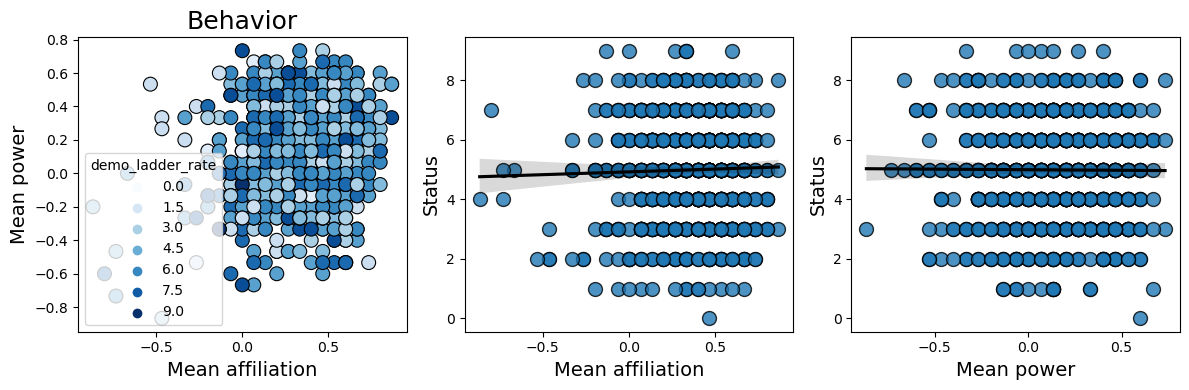

In [9]:
# 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# first subplot is scatterplot of affil_mean_mean and power_mean_mean, colored by demo_ladder_rate
sns.scatterplot(ax=axs[0], data=data, x='affil_mean_mean', y='power_mean_mean', hue='demo_ladder_rate',
                palette='Blues', s=100, edgecolor='black')
axs[0].set_xlabel('Mean affiliation', fontdict={'fontsize': 14})
axs[0].set_ylabel('Mean power', fontdict={'fontsize': 14})
axs[0].set_title('Behavior', fontdict={'fontsize': 18})

# second subplot is regplot of affil_mean_mean and demo_ladder_rate
sns.regplot(ax=axs[1], data=data, x='affil_mean_mean', y='demo_ladder_rate',
            scatter_kws={'s': 100, 'edgecolor': 'black'}, line_kws={'color': 'black'})  
axs[1].set_xlabel('Mean affiliation', fontdict={'fontsize': 14})
axs[1].set_ylabel('Status', fontdict={'fontsize': 14})

# third subplot is regplot of power_mean_mean and demo_ladder_rate
sns.regplot(ax=axs[2], data=data, x='power_mean_mean', y='demo_ladder_rate',
            scatter_kws={'s': 100, 'edgecolor': 'black'}, line_kws={'color': 'black'})
axs[2].set_xlabel('Mean power', fontdict={'fontsize': 14})
axs[2].set_ylabel('Status', fontdict={'fontsize': 14})
plt.tight_layout()



# CCA of self liking & impact to predict end location
- just self
- diff from self & realworld
- diff from self & characters
- NEXT COLLECTION: diff from self & specific characters 

In [10]:
# get the data
Xs = [['self_likability', 'self_impact'], 
      ['likability_mean', 'impact_mean'],
      ['likability_relationships_mean', 'impact_relationships_mean'], 
      ['likability_task_mean', 'impact_task_diff'], 
      ['likability_realworld_mean', 'impact_realworld_diff']]

for X_ in Xs:
      X = self_xy[X_]
      Y = self_xy[['affil_mean_mean', 'power_mean_mean']]
      try: 
            print(f'{X_}:\n')
            cca = CanCorr(X, Y)
            print(cca.corr_test().summary())
      except: 
            print(f'error: {X_}]\n')

['self_likability', 'self_impact']:

                          Cancorr results
  Canonical Correlation Wilks' lambda Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------------
0                0.2725        0.9253 4.0000 540.0000  5.3410 0.0003
1                0.0216        0.9995 1.0000 271.0000  0.1268 0.7220
--------------------------------------------------------------------
                                                                    
--------------------------------------------------------------------
Multivariate Statistics and F Approximations                        
----------------------------------------------------------------------
                         Value    Num DF    Den DF    F Value   Pr > F
----------------------------------------------------------------------
Wilks' lambda            0.9253   4.0000   540.0000    5.3410   0.0003
Pillai's trace           0.0747   4.0000   542.0000    5.2573   0.0004
Hotelling-Lawl

# Autoregression: predict the next choice from the previous trajectory + an inferred goal location
- if we assume that participants are heading to their preferred relationship quadrant, we can use their own self ratings to on every trial compute a distance and direction from current location to the preferred quadrant and assume they will go there over tiem somhow...

### Current decision ~ current location/trajectory
try to make it more complicated over time

In [3]:
# # get decision columns from data
# decisions = data.filter(regex='decision')

beh_dir = f'{base_dir}/data/Initial_2021/SNT/behavior'
behav_files = glob.glob(f'{beh_dir}/*.xlsx')
print(f'Found {len(behav_files)} behavioral files')

Found 733 behavioral files


Potential improvements:
- interactions w/ dimension?
- character specific locations

Neural network (simple MLP) classification, trying diff simple features

In [4]:
# enc = OneHotEncoder(drop='first')
# character_dummies = enc.fit_transform(decision_trials['char_role_num'].values.reshape(-1,1)).toarray()
# affil_dummy = ((decision_trials['dimension'] == 'affil') * 1)[:,np.newaxis]
# power_dummy = ((decision_trials['dimension'] == 'power') * 1)[:,np.newaxis]
# task_X = pd.DataFrame(np.hstack([character_dummies, affil_dummy, power_dummy]),
#                       columns=['second','assistant','powerful','boss','neutral','affil','power'])

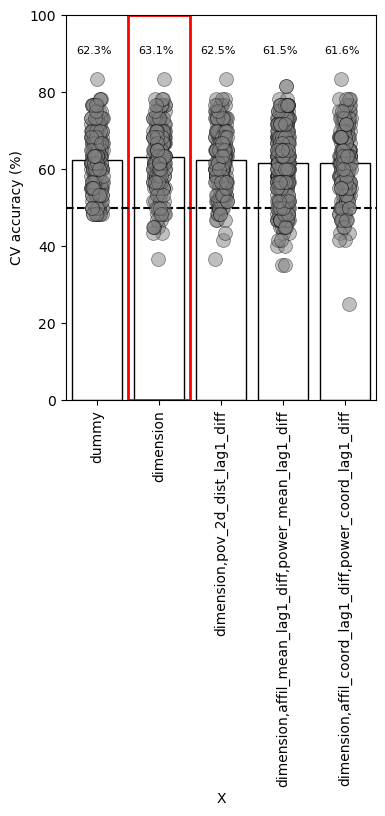

In [4]:
# does current state (eg, coordinates from last trial, or task dimension etc) affect current update?

Xs = [['dummy'],       
      ['dimension'],
      ['dimension', 'pov_2d_dist_lag1_diff'],
      ['dimension', 'affil_mean_lag1_diff', 'power_mean_lag1_diff'],
      ['dimension', 'affil_coord_lag1_diff', 'power_coord_lag1_diff']]
    #   ['dimension', 'affil_mean_lag1', 'power_mean_lag1'],
    #   ['dimension', 'char01', 'char02', 'char03', 'char04'],
    #   ['dimension', 'affil_mean_lag1_diff', 'power_mean_lag1_diff', 'char01', 'char02', 'char03', 'char04']]

lagged_vars = {'pov_2d_dist': 6, 'affil_mean': 0, 'power_mean': 0, 'affil_coord': 0, 'power_coord': 0, 'consistency': 0}
character_specific = True # lags for each character separately
onehot_encoder = OneHotEncoder(drop='first')
character_dummies = remove_neutrals(onehot_encoder.fit_transform(decision_trials['char_role_num'].values.reshape(-1, 1)).toarray())

results = pd.DataFrame(columns=['sub_id', 'X', 'cv_acc'])
for f, fname in enumerate(behav_files[0:200]):

    sub_id = fname.split('SNT_')[-1].split('_')[0]
    subject_data = pd.read_excel(fname)
    subject_data = subject_data[subject_data['char_role_num'] != 6].reset_index(drop=True)
    
    print(f'Processing {sub_id} ({f+1}/{len(behav_files)})', end='\r')

    #---------------------------------------------------------------------------------------------------------------
    # prepare data
    #---------------------------------------------------------------------------------------------------------------

    # add current trial variables: bias, dimension and character ID variables
    subject_data['bias'] = 1
    subject_data['dimension'] = (subject_data['dimension'] == 'affil') * 1
    subject_data[['char01', 'char02', 'char03', 'char04', 'char05']] = character_dummies
    
    # add previous trial variables
    if character_specific: 
        characters = []
        for c in range(1, 6):
            character = subject_data[subject_data['char_role_num'] == c]
            for (lag_var, fill), lag in itertools.product(lagged_vars.items(), range(1, 4)):
                character[f'{lag_var}_lag{lag}'] = character[lag_var].shift(lag).fillna(fill)
                character[f'{lag_var}_lag{lag}_diff'] = character[f'{lag_var}_lag{lag}'].diff(1).fillna(0)
            characters.append(character)
        subject_data = pd.concat(characters).sort_values(by=['decision_num']).reset_index(drop=True)
    else: 
        for (lag_var, fill), lag in itertools.product(lagged_vars.items(), range(1, 4)):
            subject_data[f'{lag_var}_lag{lag}'] = subject_data[lag_var].shift(lag).fillna(fill)
            subject_data[f'{lag_var}_lag{lag}_diff'] = subject_data[f'{lag_var}_lag{lag}'].diff(1).fillna(0)
    subject_data = subject_data.fillna(0)

    #---------------------------------------------------------------------------------------------------------------
    # modeling
    #---------------------------------------------------------------------------------------------------------------

    # y = current decision (dummy coded for up or down on the given dimension)
    y = (np.sum(subject_data[['affil_decision', 'power_decision']], axis=1) == 1) * 1
    y = pd.DataFrame(y, columns=['choice'])

    # X = 1-trial back behavior
    for xvars in Xs:

        try: 

            # run cross-validated logistic regression: can we predict choice from behavior?
            if 'dummy' in xvars:
                X = subject_data[['bias']]
                clf = DummyClassifier(strategy='most_frequent', random_state=0)
            else:
                X = subject_data[xvars]
                clf = LogisticRegression(solver='lbfgs', max_iter=1000, fit_intercept=True, random_state=0) # added intercept manually
            cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
            pl = make_pipeline(StandardScaler(), clf) # scale first
            cv_accs = cross_val_score(pl, X, y, cv=cv, scoring='accuracy')
            acc  = np.mean(cv_accs) * 100

        except:

            print(f'Error with {sub_id}: {xvars}')
            acc = np.nan

        results.loc[len(results)+1,:] = [sub_id, (',').join(xvars), acc]

#---------------------------------------------------------------------------------------------------------------
# plot results
#---------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(4, 5))
sns.barplot(y='cv_acc', x='X', data=results,
            edgecolor='k', linewidth=1, color='white')
sns.stripplot(y='cv_acc', x='X', data=results, 
              color='grey', size=10, alpha=0.5, 
              jitter=0.1, edgecolor='k', linewidth=0.5)
plt.axhline(50, color='k', linestyle='--')

# label the accuracies
xlabels = [x.get_text() for x in plt.gca().get_xticklabels()]
accs = []
for i, X in enumerate(xlabels):
    acc = np.mean(results[results['X'] == X]['cv_acc'])
    plt.text(i-.33, 90, f"{acc:.1f}%", fontsize=8)
    accs.append(acc)
plt.gca().add_patch(Rectangle((accs.index(max(accs))-.5, 0), 1, 100,
                               fill=False, edgecolor='red', lw=2))
plt.ylim(0, 100)
plt.ylabel('CV accuracy (%)')
plt.xticks(rotation=90)
plt.show()

In [187]:
# accs = results['cv_acc'].values.astype(float)
# accs = accs[np.isfinite(accs)]
# for chance in range(50,61,2):
#     t, p = scipy.stats.ttest_1samp(accs, chance, alternative='greater')
#     print(f'Chance level: {chance}%, p = {p:.3f}')

In [98]:
# if the columns dont exist in data merge
if 'affil_coef' not in data.columns:
    data = data.merge(results, on='sub_id')
# else overwrite
else:
    data['affil_coef'] = results['affil_coef']
    data['power_coef'] = results['power_coef']
    data['prsqr'] = results['prsqr']

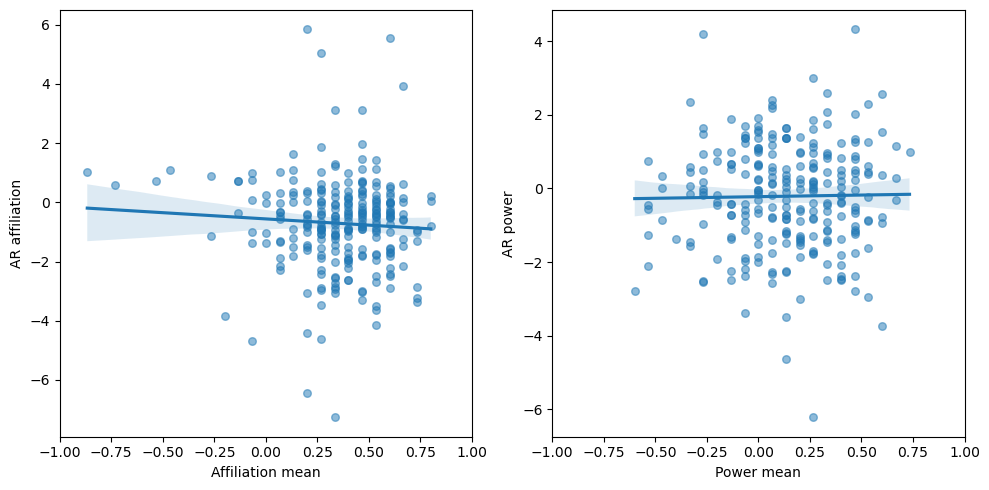

In [99]:
# 2 subplots
fig, ax = plt.subplots(1,2, figsize=(10,5))
# first subplot: results[cv_acc] when the model is trained on affil_mean against affil_mean
sns.regplot(x='affil_mean', y='cv_acc', data=results, ax=ax[0], color='grey', scatter_kws={'alpha':0.5})


In [ ]:
# some kind of cross-subject rsa

# Assume a bias to a quadrant that they will try to minimize distance to on each trial....

In [ ]:
# for each trial, compute distance from each hypothetical next location (current + update) to preferred end location (from social avoidance factor, status, etc)